###Q1

In [ ]:
from torch import nn
import torch
from torchvision.models import resnet50

class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6, num_queries=100):
        super().__init__()


        self.backbone = resnet50()
        del self.backbone.fc

        self.conv = nn.Conv2d(2048, hidden_dim, 1)


        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)


        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)


        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))


        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):

        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)


        h = self.conv(x)


        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)


        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)


        pred_logits = self.linear_class(h)
        pred_boxes = self.linear_bbox(h)

        return {'pred_logits': pred_logits, 'pred_boxes': pred_boxes}

if __name__ == '__main__':
    detr = DETR(num_classes=10)
    print(detr)


DETR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

###Discussion

The DETR model, leveraging ResNet-50 and transformers, highlights several insights:

1. **Integration of Pre-trained Networks**: ResNet-50 helps extract robust features essential for transformers in object detection.
2. **Transformers for Spatial Data**: Adapting transformers for image-based tasks shows their flexibility beyond NLP.
3. **Positional Encodings**: These are critical for maintaining spatial relationships, crucial for accurate object detection.
4. **Simplified Architecture**: DETR streamlines the detection process, reducing the need for complex traditional methods.
5. **Resource Demands**: Despite its streamlined nature, DETR requires significant computational resources, which could be a drawback for some applications.

###Q2

In [ ]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn


from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()



Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


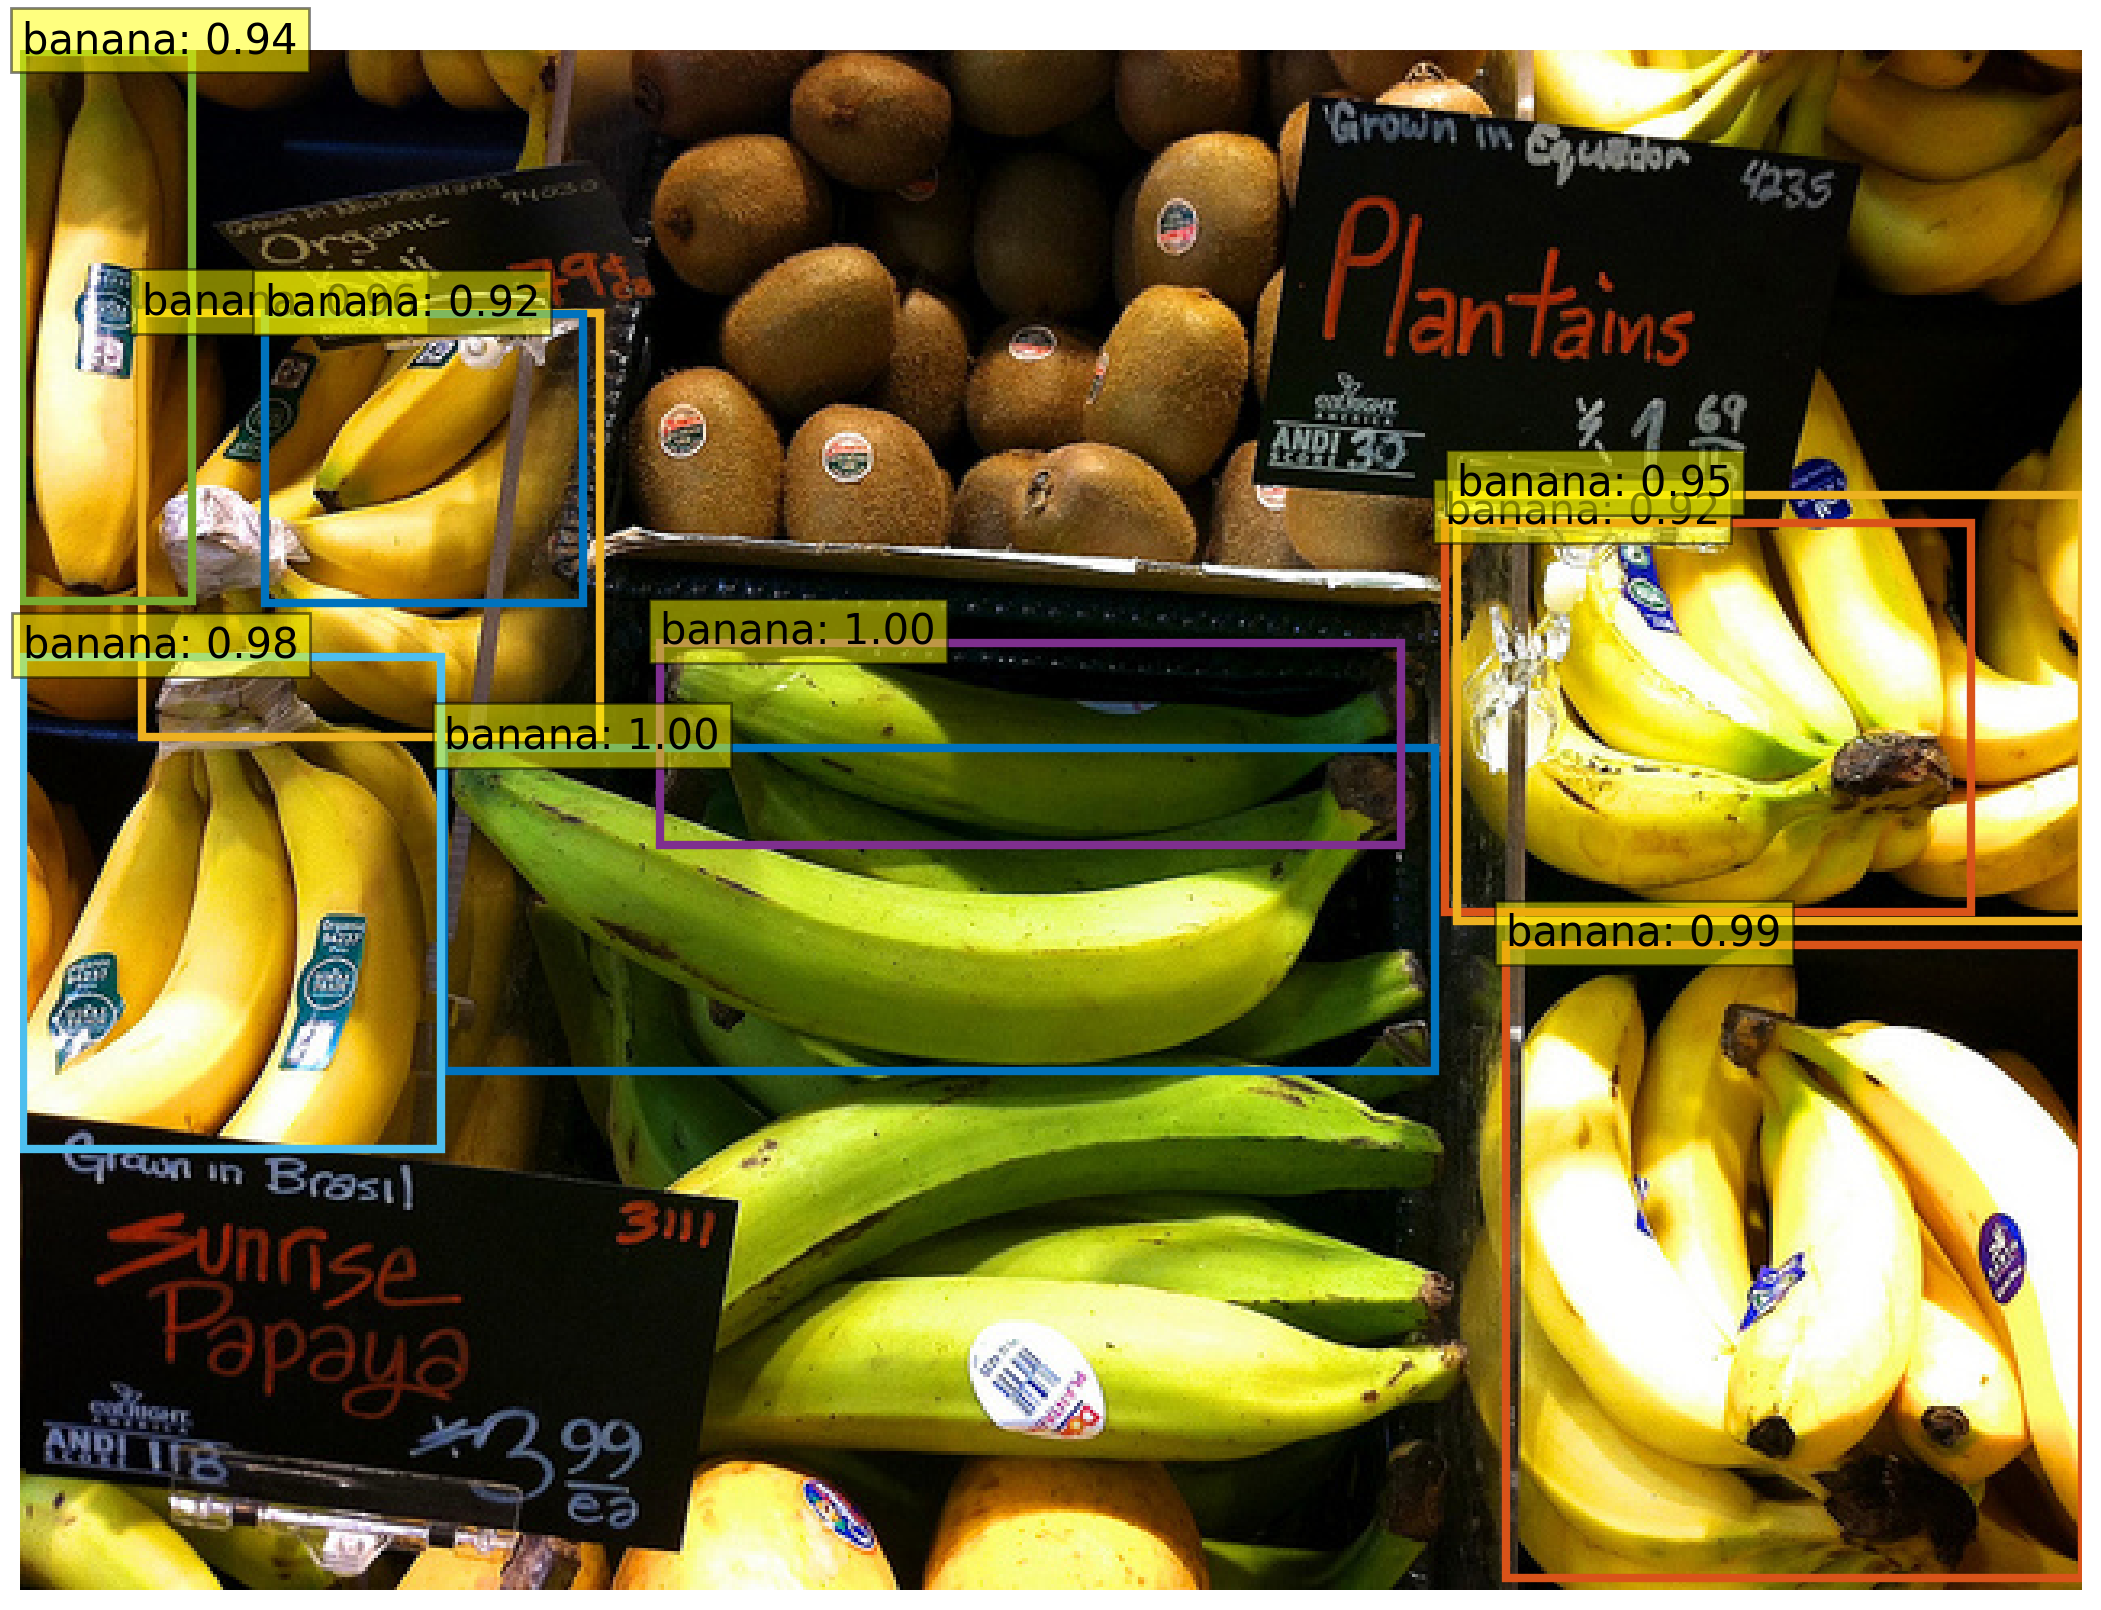

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

# Use a direct link to a COCO dataset image
url = 'http://images.cocodataset.org/val2017/000000581781.jpg'
im = Image.open(requests.get(url, stream=True).raw)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)


In [ ]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img) # put your own image

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

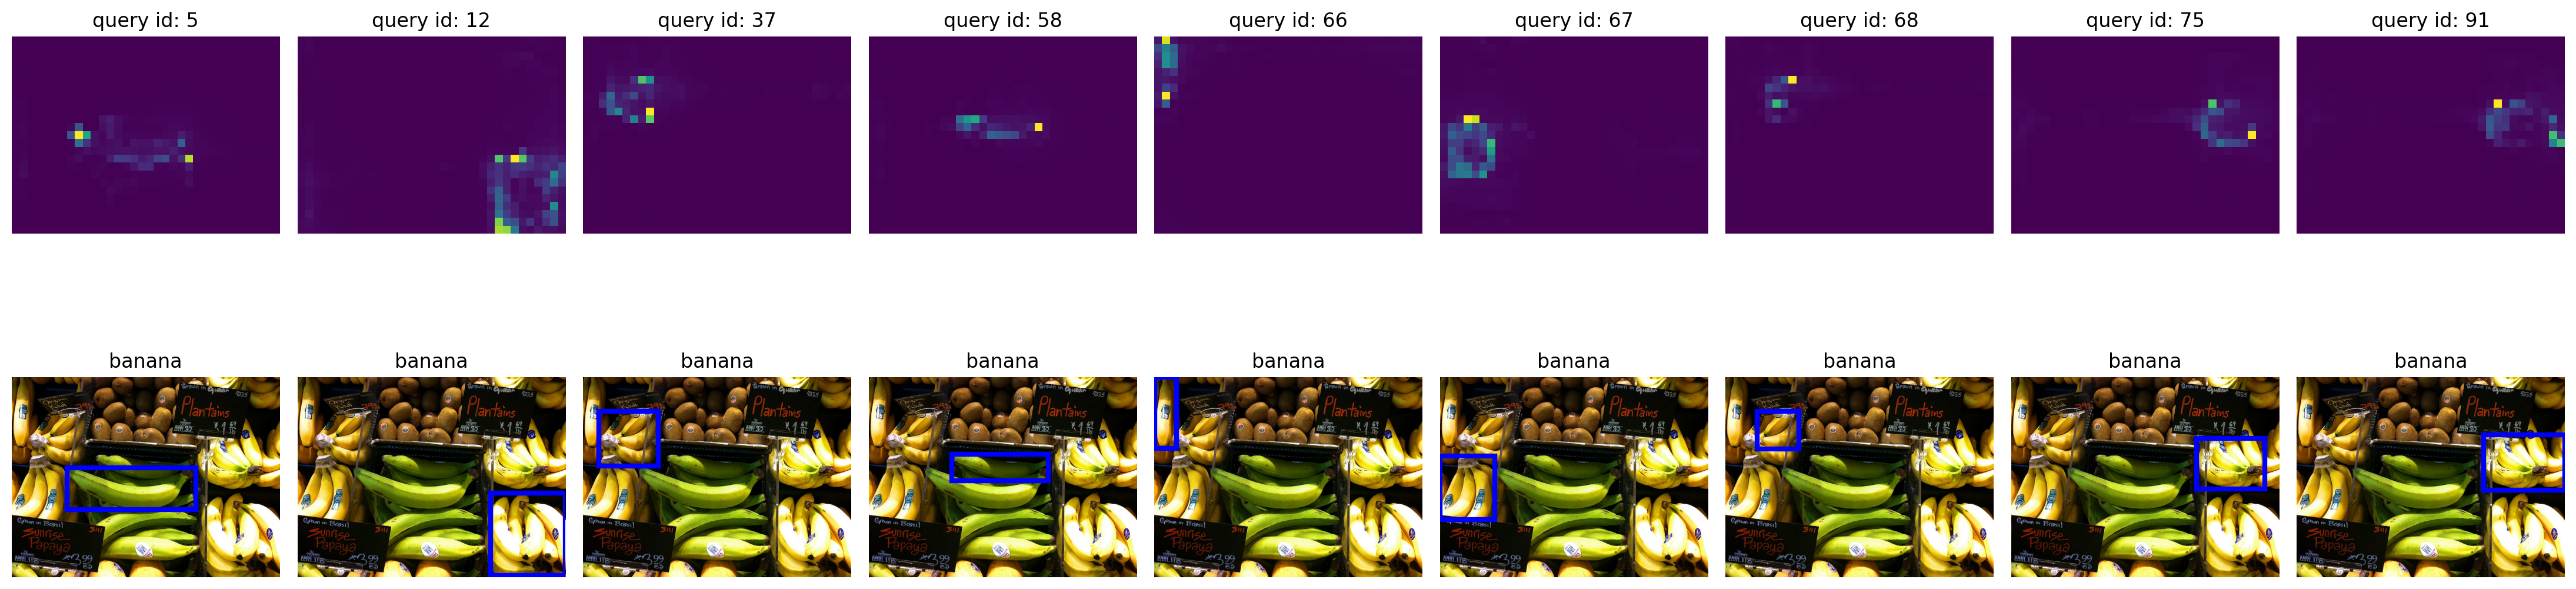

In [ ]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

In [ ]:
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([850, 850])
Feature map:             torch.Size([1, 2048, 25, 34])


In [ ]:
shape = f_map.tensors.shape[-2:]
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 34, 25, 34])


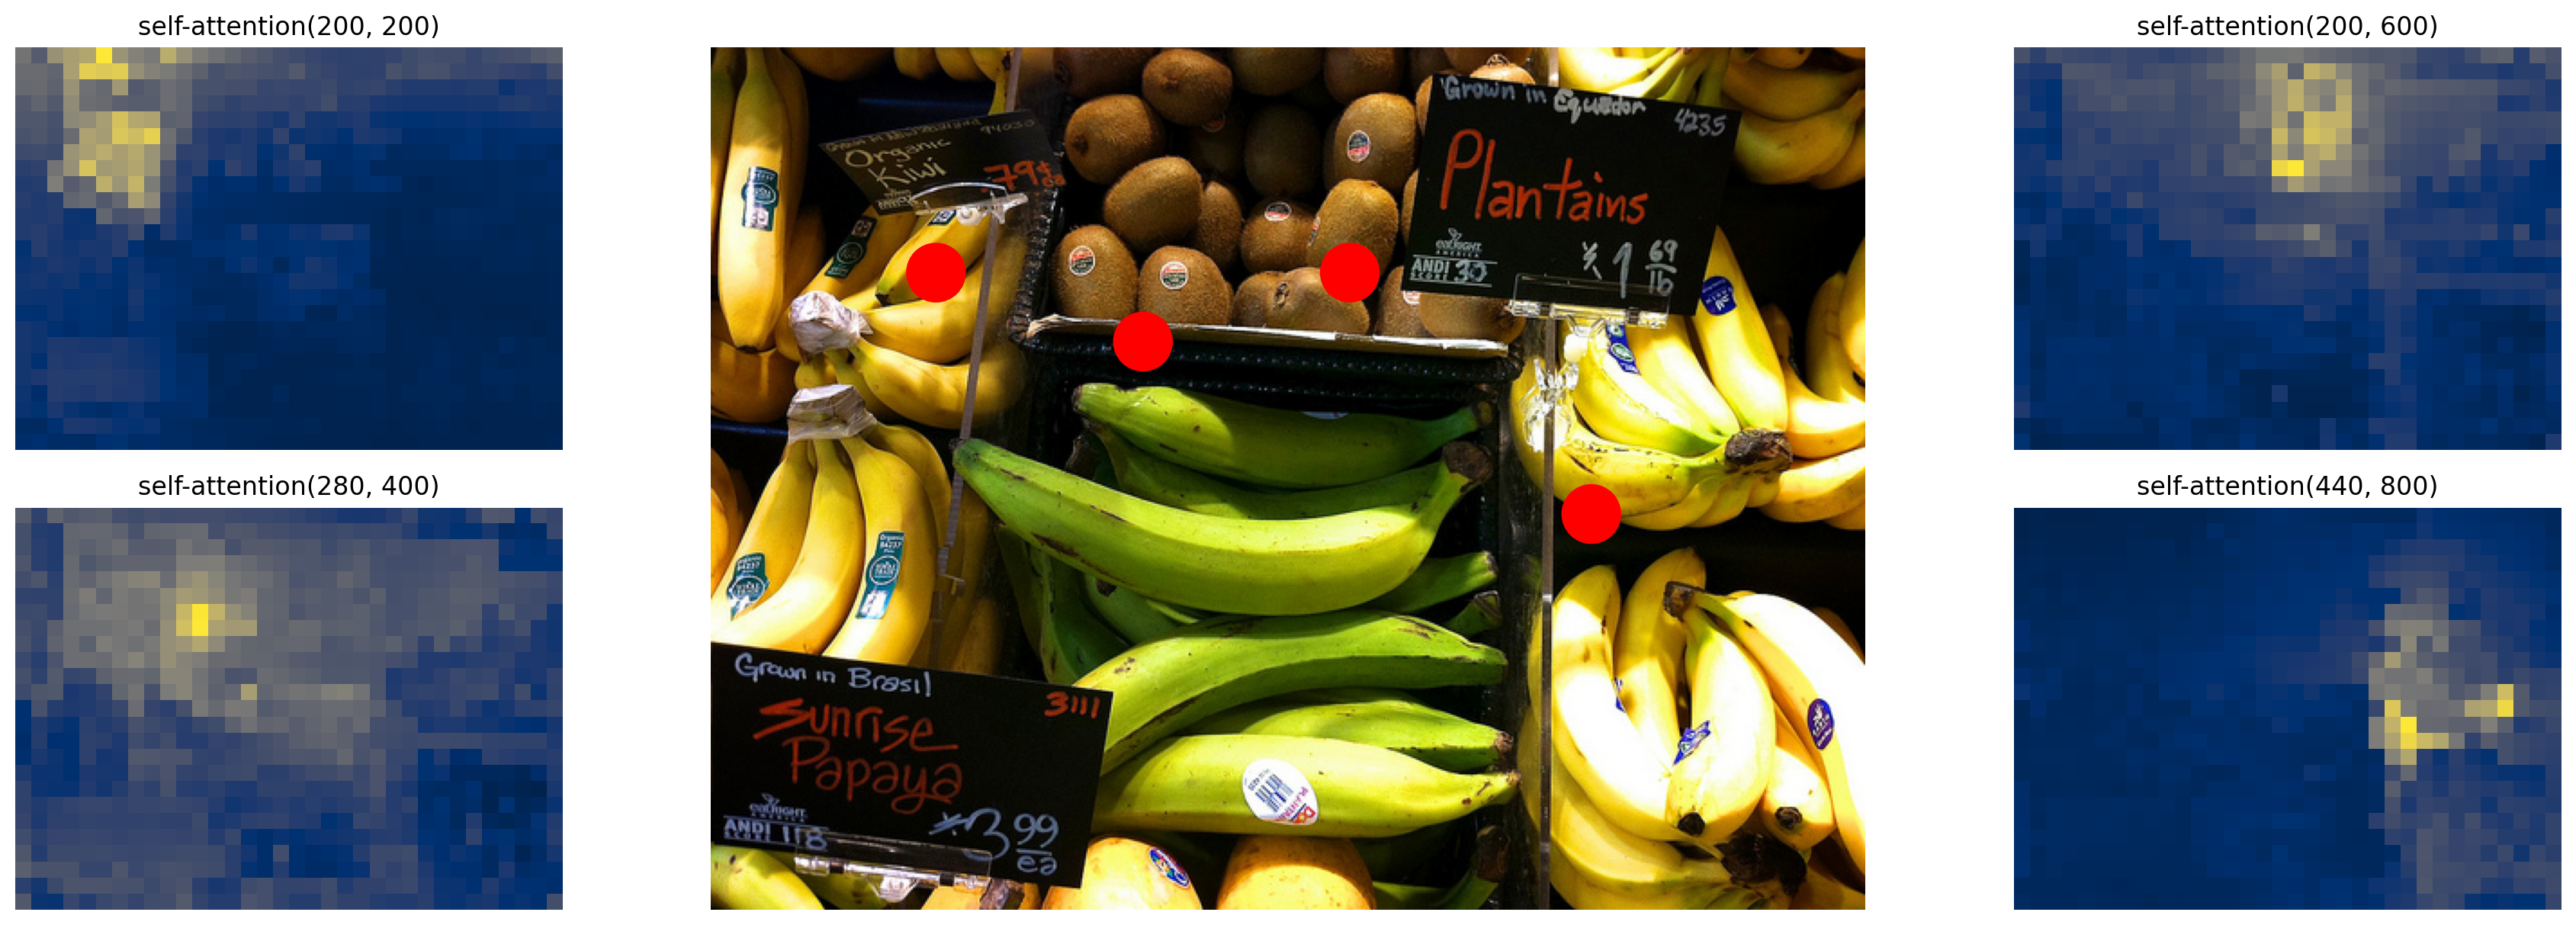

In [ ]:
fact = 32

idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))

gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')


fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

###Discussion

The application of the DETR model for object detection in an urban scene from the COCO dataset highlights several key points:

1. **Effectiveness**: DETR uses a transformer architecture that predicts objects and their bounding boxes effectively, demonstrating robust performance even in complex scenes.
   
2. **Attention Mechanism**: Visualizing the model’s attention helps understand its focus areas within the image, showing how it identifies relevant objects.

3. **Real-world Applications**: The test underscores DETR's potential for use in areas like surveillance and autonomous driving, where precise object detection is crucial.

4. **Challenges**: Despite its strengths, DETR faces issues like computational demands and the need for extensive training datasets, highlighting areas for future improvement.

5. **Parameter Tuning**: Adjusting DETR's parameters can significantly affect its detection accuracy, indicating the need for careful setup based on the use case.

This summary emphasizes DETR’s utility and areas for enhancement, providing insights into its integration and optimization for practical applications.

###Q3

**Understanding Attention Mechanisms in DETR**

DETR (DEtection TRansformer) employs distinct attention mechanisms in its encoder and decoder to facilitate object detection. Here’s a breakdown of the types of attention used and their characteristics:

### Encoder Attention
The encoder of DETR utilizes self-attention, a mechanism that allows inputs to interact with each other ("self") and find out which features to focus on. Self-attention in the encoder processes the entire input image as a sequence of features, helping the model to understand the global context of the image. This mechanism is crucial for recognizing relationships and dependencies across different parts of the image.

### Decoder Attention
The decoder, on the other hand, employs cross-attention mechanisms. This type of attention allows the decoder to focus on specific parts of the input image features that are relevant to predicting the output, such as the presence and location of objects. Each decoder layer in DETR uses cross-attention to refer back to the output of the encoder, enabling it to focus on the most relevant features identified by the encoder.

### Key Differences
- **Scope of Attention**: While encoder attention processes all features globally, decoder attention selectively focuses on parts of the image features that are most relevant for predicting each specific object.
- **Direction of Focus**: The encoder's self-attention looks at the whole image to capture context, whereas the decoder's cross-attention targets specific areas guided by the object queries.

### Analysis from Visualized Results
From the visualizations in Q2, it's evident that:
- **Encoder Attention**: This mechanism spreads its focus broadly across the image to capture a comprehensive understanding of the scene. This global view supports the decoder's finer, targeted tasks.
- **Decoder Attention**: It homes in on specific areas. For example, if the task is to detect a car, decoder attention mechanisms focus on regions where cars are typically found, ignoring irrelevant regions like the sky.

**Insights**: The attention visualizations show how DETR distinguishes between background and foreground, essential for tasks like segmentation and precise localization of objects. This dual attention mechanism allows DETR to be both broad and specific in focus, making it robust for complex scenes where multiple objects interact or overlap.

These characteristics highlight the sophisticated interplay between the encoder and decoder in DETR, showcasing the model's ability to adapt its focus dynamically based on the task at hand, leading to effective detection performance.